In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from IPython.display import display, HTML


# Download data

In [283]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')
train['timestamp'] = train['timestamp'].apply(pd.to_datetime)

In [284]:
def num_houses_with_bigger_column_value (column_name, value):
    return len(train[train[column_name] > value].index)

def num_houses_with_less_column_value (column_name, value):
    return len(train[train[column_name] < value].index)

In [285]:
def plot_feature_kde(column_name, min_value, max_value):
    data = train[column_name]
    data = data.where(data.notnull(), axis=0)
    data = data[(min_value <= data) & (data <= max_value)]
    ax = sns.kdeplot(data=data, shade=True)
    ax.set(xlabel= column_name, ylabel='density')

def plot_regplot(column_name1, column_name2, col1_min, col1_max, col2_min, col2_max, alpha=0.1):
    reg_plot_data = train[[column_name1, column_name2]]
    reg_plot_data = reg_plot_data[(col1_min <= train[column_name1]) & (train[column_name1] <= col1_max) \
                                & (col2_min <= train[column_name2]) & (train[column_name2] <= col2_max)]
    sns.regplot(x=reg_plot_data[column_name1], y=reg_plot_data[column_name2], \
              scatter_kws={'alpha':alpha})

def plot_features_jointplot(column_name1, column_name2, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2]]
    data = data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.jointplot(column_name1, column_name2, data=data, kind="kde", space=0, color="b", \
                scatter_kws={'alpha':alpha})

def plot_lmplot(column_name1, column_name2, hue, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2, hue]]
    data=data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.lmplot(x=column_name1, y=column_name2, hue=hue, data=data, scatter_kws={'alpha':alpha})

def plot_distplot(column_name):
    sns.distplot(a=train[column_name], kde=False)

## &emsp; Data processing



In [286]:
import math

def change_life_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1 / 0.67:
        return row['life_sq'] - row['full_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['full_sq']
    return row['life_sq']

def change_full_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1.3:
        return row['life_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['life_sq']
    return row['full_sq']

def account_kitch_sq (row):
    if row['kitch_sq'] >= 0 and row['kitch_sq'] < row['full_sq_help']:
        return row['full_sq_help'] - row['kitch_sq']
    return row['life_sq_help']

def custom_pipeline(data_recieved, is_train=True):
    data = data_recieved.copy()
    
    if is_train:
        data.drop(data[data['full_sq'] > 1000].index, inplace=True)
        data.drop(data[data['build_year'] > 2018].index, inplace=True)
        data.drop(data[(data['full_sq'] == 0) & (data['life_sq'] == 0) & (data['kitch_sq'] == 0)].index, \
                  inplace=True)

    mean_division_value = 0.67
    
    data['life_sq/full_sq'] = data['life_sq'] / (data['full_sq'] + 1)
    data['life_sq/full_sq'].mask(np.isinf(data['life_sq/full_sq']), inplace=True)
    data['life_sq/full_sq'].fillna(mean_division_value, inplace=True)

    data.loc[data['life_sq'] > 200, 'life_sq'] = \
                                    data[data['life_sq'] > 200].apply(lambda x: \
                                    x['full_sq'] - x['kitch_sq'] if x['kitch_sq'] >= 0 else x['full_sq'], axis=1)

    mean_value = data['life_sq/full_sq'].mean()
    data['life_sq'] = data.apply(lambda x: x['life_sq'] if not pd.isnull(x['life_sq']) \
                                   else x['full_sq'] * mean_value, axis=1)
    
    data_help = data[['full_sq', 'life_sq', 'kitch_sq', 'life_sq/full_sq']].copy()
    data_help['life_sq_help'] = data_help.apply(change_life_sq, axis=1)
    data_help['full_sq_help'] = data_help.apply(change_full_sq, axis=1)
    data_help['life_sq_help'] = data_help.apply(account_kitch_sq, axis=1)
    data_help['life_sq_help'] = data_help.apply(lambda x: x['life_sq_help'] \
                                if not pd.isnull(x['life_sq_help']) else x['full_sq_help'] * mean_value, axis=1)
    data[['full_sq', 'life_sq']] = data_help[['full_sq_help', 'life_sq_help']]
    data.loc[data['life_sq/full_sq'] > 0.9, 'life_sq'] = \
                    data.loc[data['life_sq/full_sq'] > 0.9].apply(lambda x: x['full_sq'] * mean_value, axis=1)
    
    data.loc[:, 'life_sq'] = data.apply(lambda x: math.ceil(x['life_sq']), axis=1)
    data['life_sq/full_sq'] = (data['life_sq'] + 1) / (data['full_sq'] + 1)
    data['full_sq/life_sq'] = 1 / data['life_sq/full_sq']
    data['kitch_sq'] = data.apply(lambda x: x['full_sq'] - x['life_sq'] , axis = 1)
    data['life_sq/kitch_sq'] = (data['life_sq']) / (data['kitch_sq'] + 1)
    
    data_help = data[['kitch_sq', 'life_sq', 'full_sq', 'life_sq/kitch_sq', 'num_room']].copy()
    data_help['life_sq_help'] = data_help.apply(lambda x: x['kitch_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['life_sq'], axis=1)
    data_help['kitch_sq_help'] = data_help.apply(lambda x: x['life_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['kitch_sq'], axis=1)
    data[['life_sq', 'kitch_sq']]= data_help[['life_sq_help', 'kitch_sq_help']]
    
    data['life_sq/full_sq'] = (data['life_sq'] + 1) / (data['full_sq'] + 1)
    data['life_sq/kitch_sq'] = (data['life_sq'] + 1) / (data['kitch_sq'] + 1)
    data['full_sq/life_sq'] = 1 / data['life_sq/full_sq']
    data['kitch_sq/life_sq'] = 1 / data['life_sq/kitch_sq']
    
    data.rename(columns={'kitch_sq' : 'other_sq'}, inplace=True)
    
    data.loc[:, 'full_sq'] = data.apply(lambda x: round(x['full_sq']), axis=1)
    data.loc[:, 'life_sq'] = data.apply(lambda x: round(x['life_sq']), axis=1)
    data.loc[:, 'other_sq'] = data.apply(lambda x: round(x['other_sq']), axis=1)
    
    return data

In [287]:
train = custom_pipeline(train)

## &emsp; floor, max_floor and build_year

In [288]:
train[['floor', 'max_floor']].describe()

,floor,max_floor
count,30300.000000,20896.000000
mean,7.670990,12.559772
std,5.320027,6.756431
min,0.000000,0.000000
25%,3.000000,9.000000
50%,6.500000,12.000000
75%,11.000000,17.000000
max,77.000000,117.000000


In [289]:
train[['floor', 'max_floor']].median()

floor         6.5
max_floor    12.0
dtype: float64

In [290]:
train[['floor', 'max_floor']].isna().sum()

floor         167
max_floor    9571
dtype: int64

/home/sergei/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


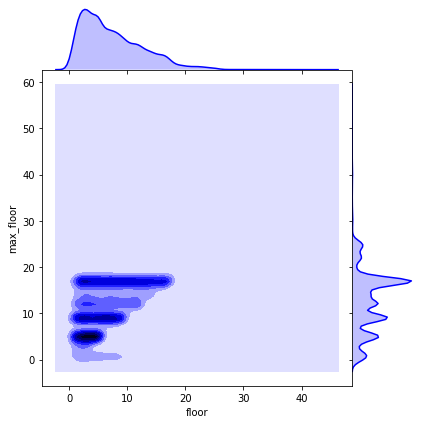

In [291]:
plot_features_jointplot('floor', 'max_floor', 0, 60, 0, 60)

As we can see floors are equally destributed in [0; max_floor].

Also the most popular max_floor values are 5, 9, 12 and 17.

In [292]:
train[train['max_floor'] < train['floor']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
8219,2013-05-29,58,58,13.0,0.0,1.0,NaN,2.0,0,NaN,...,7,1,0,12,1,5813760,1.000000,1.000000,59.000000,0.016949
8271,2013-05-31,93,33,3.0,1.0,1.0,2013.0,3.0,60,1.0,...,3,0,0,0,0,5427640,0.361702,2.764706,0.557377,1.794118
8502,2013-06-14,37,37,2.0,0.0,1.0,1979.0,1.0,0,2.0,...,23,1,0,52,5,6000000,1.000000,1.000000,38.000000,0.026316
8534,2013-06-17,34,26,7.0,0.0,6.0,NaN,1.0,8,1.0,...,7,1,0,12,1,3842500,0.771429,1.296296,3.000000,0.333333
8915,2013-07-03,51,43,5.0,0.0,1.0,1997.0,2.0,8,1.0,...,29,1,2,74,11,3850000,0.846154,1.181818,4.888889,0.204545


In [293]:
train[train['max_floor'] < train['floor']].shape[0]

1493

The easiest way to edit this mismatch would be to simply max_floor = floor.
We should also look at interconnection between max_floor and build_year.

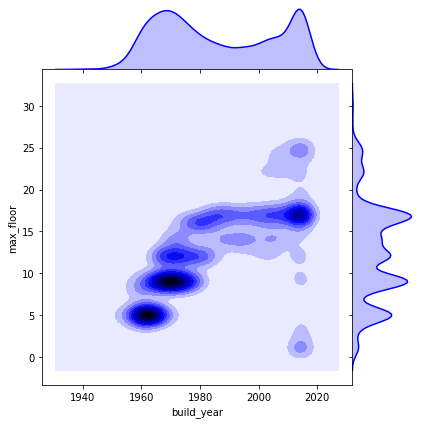

In [294]:
plot_features_jointplot('build_year', 'max_floor', 1940, 2018, 1, 30)

In [295]:
d = dict()
for year in range(1940, 2020, 10):
    print('Year:', year - 10, '-', year, 'median = ', train[(year - 10 <= train['build_year']) \
                                                          & (train['build_year'] < year)]['max_floor'].median())
    d[year] = train[(year - 10 <= train['build_year']) & (train['build_year'] < year)]['max_floor'].median()

Year: 1930 - 1940 median =  5.5
Year: 1940 - 1950 median =  7.0
Year: 1950 - 1960 median =  5.0
Year: 1960 - 1970 median =  8.0
Year: 1970 - 1980 median =  12.0
Year: 1980 - 1990 median =  16.0
Year: 1990 - 2000 median =  16.0
Year: 2000 - 2010 median =  17.0


In [296]:
train[train['build_year'] < 1930]['max_floor'].median()

10.0

That seems extremely strange. Let's fix all the mentioned problems.

In [297]:
train[(pd.isnull(train['build_year']) & (pd.isnull(train['max_floor']) & (pd.isnull(train['floor']))))]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
179,2011-10-22,98,63,NaN,NaN,NaN,NaN,NaN,35,NaN,...,3,0,0,10,0,11500000,0.646465,1.546875,1.777778,0.562500
188,2011-10-24,49,29,NaN,NaN,NaN,NaN,NaN,20,NaN,...,30,0,7,66,16,8300000,0.600000,1.666667,1.428571,0.700000
196,2011-10-25,37,23,NaN,NaN,NaN,NaN,NaN,14,NaN,...,32,0,7,69,12,2000000,0.631579,1.583333,1.600000,0.625000
216,2011-10-26,45,27,NaN,NaN,NaN,NaN,NaN,18,NaN,...,18,1,1,41,5,2825000,0.608696,1.642857,1.473684,0.678571
295,2011-11-05,33,20,NaN,NaN,NaN,NaN,NaN,13,NaN,...,17,0,9,51,11,1000000,0.617647,1.619048,1.500000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,2013-08-08,146,94,NaN,NaN,NaN,NaN,NaN,52,NaN,...,4,0,0,2,1,5571000,0.646259,1.547368,1.792453,0.557895
9730,2013-08-09,82,53,NaN,NaN,NaN,NaN,NaN,29,NaN,...,7,0,0,3,2,3502000,0.650602,1.537037,1.800000,0.555556
9850,2013-08-15,79,41,NaN,NaN,NaN,NaN,NaN,38,NaN,...,7,1,0,12,1,6934500,0.525000,1.904762,1.076923,0.928571


In [298]:
def fill_max_floor (row):
    if not pd.isnull(row['build_year']) and row['build_year'] < 1930:
        return 2
    if not pd.isnull(row['max_floor']):
        return row['max_floor']
    if not pd.isnull(row['build_year']) and row['build_year'] > 0:
        dict_year = (row['build_year'] // 10) * 10
        if dict_year < 1930:
            return 2
        else:
            return d[dict_year]
    if not pd.isna(row['floor']):
        if row['floor'] > 16:
            return row['floor']
        if row['floor'] > 12:
            return 16
        if row['floor'] > 8:
            return 12
    return 8

In [299]:
train['max_floor'] = train.apply(lambda x: x['floor'] if x['floor'] > x['max_floor'] else x['max_floor'], axis=1)

In [300]:
train['max_floor'] = train.apply(fill_max_floor, axis=1)

In [301]:
train[pd.isnull(train['floor'])].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
179,2011-10-22,98,63,NaN,8.0,NaN,NaN,NaN,35,NaN,...,3,0,0,10,0,11500000,0.646465,1.546875,1.777778,0.562500
188,2011-10-24,49,29,NaN,8.0,NaN,NaN,NaN,20,NaN,...,30,0,7,66,16,8300000,0.600000,1.666667,1.428571,0.700000
196,2011-10-25,37,23,NaN,8.0,NaN,NaN,NaN,14,NaN,...,32,0,7,69,12,2000000,0.631579,1.583333,1.600000,0.625000
216,2011-10-26,45,27,NaN,8.0,NaN,NaN,NaN,18,NaN,...,18,1,1,41,5,2825000,0.608696,1.642857,1.473684,0.678571
295,2011-11-05,33,20,NaN,8.0,NaN,NaN,NaN,13,NaN,...,17,0,9,51,11,1000000,0.617647,1.619048,1.500000,0.666667


In [302]:
train[train['floor'] > train['max_floor']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
8936,2013-07-04,106,98,4.0,2.0,2.0,1917.0,5.0,8,2.0,...,241,2,102,196,13,22800000,0.925234,1.080808,11.000000,0.090909
9444,2013-07-25,73,26,5.0,2.0,1.0,0.0,3.0,47,NaN,...,7,0,0,6,0,5626933,0.364865,2.740741,0.562500,1.777778
9623,2013-08-05,65,64,7.0,2.0,1.0,1.0,2.0,1,1.0,...,9,0,0,38,4,5415070,0.984848,1.015385,32.500000,0.030769
9703,2013-08-08,60,59,24.0,2.0,1.0,1.0,2.0,1,1.0,...,7,0,0,6,0,5402275,0.983607,1.016667,30.000000,0.033333
9748,2013-08-09,39,26,10.0,2.0,1.0,1.0,1.0,13,1.0,...,3,0,0,6,1,3984760,0.675000,1.481481,1.928571,0.518519


In [303]:
train['build_year'].nunique()

117

In [304]:
train[(0 < train['build_year']) & (train['build_year'] < 1930)]['build_year'].value_counts().sort_index()

1.0       368
3.0         2
20.0        1
71.0        1
215.0       1
1691.0      1
1860.0      2
1876.0      1
1886.0      1
1890.0      5
1895.0      1
1896.0      2
1900.0      2
1904.0      1
1905.0      1
1906.0      1
1907.0      2
1910.0      5
1911.0      1
1912.0      5
1914.0      3
1915.0      5
1917.0     16
1920.0      1
1924.0      3
1925.0      1
1926.0      8
1927.0     10
1928.0     12
1929.0     12
Name: build_year, dtype: int64

As we can see, we have some strange build_year values like 1, 3, 20, 71 etc.

In [305]:
train['build_year'].isna().sum() + len(train[train['build_year'] < 1860].index)

14507

In [306]:
train[train['build_year'] > 1860]['build_year'].describe()

count    15958.000000
mean      1985.385763
std         20.821060
min       1876.000000
25%       1968.000000
50%       1981.000000
75%       2006.000000
max       2018.000000
Name: build_year, dtype: float64

In [307]:
train.loc[train['build_year'] < 1860, 'build_year'] = np.nan

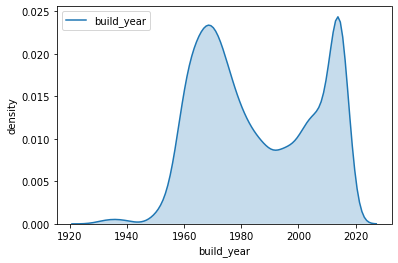

In [308]:
plot_feature_kde('build_year', 1930, 2018)

In my opnion the best option would be to Impute build_year column and keep track of Imputed values. (Otherwise we'll ruin the destribution).

In [309]:
my_build_Imputer = SimpleImputer(strategy="median")

def impute_build_year(train):
    train['build_year was_missing'] = train[['build_year']].isnull() 
    my_build_Imputer.fit(train[['build_year']])
    train.loc[:, 'build_year'] = my_build_Imputer.transform(train[['build_year']])

In [310]:
impute_build_year(train)

In [311]:
train.head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq,build_year was_missing
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27,4.0,8.0,NaN,1981.0,NaN,16,NaN,...,1,0,52,4,5850000,0.636364,1.571429,1.647059,0.607143,True
2,2011-08-23,34,19,3.0,8.0,NaN,1981.0,NaN,15,NaN,...,1,10,66,14,6000000,0.571429,1.750000,1.250000,0.800000,True
3,2011-08-27,43,29,2.0,8.0,NaN,1981.0,NaN,14,NaN,...,0,4,67,10,5700000,0.681818,1.466667,2.000000,0.500000,True
4,2011-09-01,89,50,9.0,12.0,NaN,1981.0,NaN,39,NaN,...,0,0,26,3,13100000,0.566667,1.764706,1.275000,0.784314,True
5,2011-09-05,77,50,4.0,8.0,NaN,1981.0,NaN,27,NaN,...,2,91,195,14,16331452,0.653846,1.529412,1.821429,0.549020,True


In [312]:
train.loc[:, ['floor', 'max_floor']].isna().sum().sum()

167

In [313]:
train['floor'].isna().sum()

167

In [314]:
train['floor was_missing'] = train['floor'].isnull()

In [315]:
train['floor'] = train.apply(lambda x: x['max_floor'] // 2 if pd.isnull(x['floor']) \
                             else x['floor'], axis=1)

# Strange features analysis

In [316]:
train.columns[train.isna().sum() > 0]

Index(['material', 'num_room', 'state', 'preschool_quota', 'school_quota',
       'hospital_beds_raion', 'raion_build_count_with_material_info',
       'build_count_block', 'build_count_wood', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk',
       'metro_km_walk', 'railroad_station_walk_km',
       'railroad_station_walk_min', 'ID_railroad_station_walk',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
     

In [317]:
strange_columns = []

for column in train.columns:
    if ('max' in train[column].describe().index and  train[column].describe()['max'] > \
        train[column].describe()['mean'] + 10 * train[column].describe()['std']) \
    or ('min' in train[column].describe().index and train[column].describe()['min'] < \
        train[column].describe()['mean'] - 10 * train[column].describe()['std']):
        strange_columns.append(column)

In [318]:
train[strange_columns].describe().iloc[:, :10]

,full_sq,life_sq,floor,max_floor,num_room,other_sq,metro_km_avto,kindergarten_km,school_km,park_km
count,30467.000000,30467.000000,30467.000000,30467.000000,20896.000000,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000
mean,54.057603,41.058424,7.650868,12.027538,1.909935,12.999179,3.701702,0.981754,1.324064,3.100145
std,23.100261,20.190264,5.312345,5.871700,0.851740,14.158597,5.808768,2.122084,3.058330,3.965582
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000470,0.000000,0.003737
25%,38.000000,27.000000,3.000000,8.000000,1.000000,6.000000,1.036568,0.199946,0.269716,0.973297
50%,49.000000,38.000000,6.000000,12.000000,2.000000,9.000000,1.783625,0.353762,0.474862,1.803889
75%,63.000000,50.000000,11.000000,17.000000,2.000000,17.000000,3.776836,0.971417,0.886531,3.404787
max,729.000000,634.000000,77.000000,117.000000,19.000000,685.000000,74.905763,29.085774,47.394706,47.351538


In [319]:
train[strange_columns].describe().iloc[:, 10:17]

,industrial_km,public_transport_station_km,public_transport_station_min_walk,ts_km,market_shop_km,fitness_km,swim_pool_km
count,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000
mean,0.768845,0.414151,4.969812,4.931402,3.958953,1.154644,4.232571
std,0.717972,1.272571,15.270853,4.804445,3.447696,1.541508,4.626271
min,0.000000,0.002804,0.033646,0.000000,0.003847,0.000000,0.000000
25%,0.288289,0.101312,1.215747,2.057437,1.543631,0.361170,1.709065
50%,0.576464,0.160245,1.922940,3.972224,2.927417,0.656267,2.876573
75%,1.041085,0.278350,3.340196,5.551858,5.485423,1.333994,5.369801
max,14.048162,17.413002,208.956022,54.080913,41.103651,26.652505,53.359294


In [320]:
train[strange_columns].describe().iloc[:, 17:24]

,hospice_morgue_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,additional_education_km,preschool_km
count,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000
mean,2.646611,3.356918,6.855842,3.926849,1.505784,1.328552,1.345327
std,2.952545,4.342061,6.731432,4.907704,2.253877,1.526307,3.053790
min,0.002517,0.000000,0.000313,0.000000,0.000000,0.000000,0.000000
25%,1.118164,1.279126,2.201645,1.016728,0.483695,0.474767,0.285055
50%,1.896035,2.341579,4.337579,2.031689,0.839453,0.899242,0.493048
75%,3.297318,3.983903,9.380269,5.415663,1.549215,1.571087,0.936324
max,43.694640,76.055135,84.862148,55.278225,26.259543,24.268209,47.394706


In [321]:
train[strange_columns].describe().iloc[:, 24:32]

,big_church_km,church_synagogue_km,theater_km,catering_km,office_count_500,office_sqm_500,trc_sqm_500,cafe_count_500
count,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,3.046700e+04,30467.000000
mean,2.330183,0.972029,9.638127,0.688014,0.740834,13984.823054,2.180012e+04,3.871894
std,2.987100,0.748897,7.112122,0.832955,2.283475,42612.588292,8.158513e+04,11.284599
min,0.004072,0.000000,0.026788,0.000357,0.000000,0.000000,0.000000e+00,0.000000
25%,0.860469,0.532480,4.225254,0.208621,0.000000,0.000000,0.000000e+00,0.000000
50%,1.490760,0.860037,8.612007,0.412701,0.000000,0.000000,0.000000e+00,1.000000
75%,2.922658,1.248480,13.459593,0.841418,0.000000,0.000000,1.200000e+02,3.000000
max,45.669060,15.615728,87.600690,12.162697,34.000000,611015.000000,1.500000e+06,120.000000


In [322]:
train[strange_columns].describe().iloc[:, 32:37]

,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000
count,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000
mean,0.993797,0.980011,0.843765,0.542882,0.138642
std,3.060624,2.268587,2.318642,2.137503,0.689227
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000
max,33.000000,39.000000,29.000000,22.000000,14.000000


In [323]:
train[strange_columns].describe().iloc[:, 37:43]

,cafe_count_500_price_high,mosque_count_500,leisure_count_500,office_sqm_1000,cafe_count_1000_price_1000,cafe_count_1000_price_2500
count,30467.000000,30467.000000,30467.000000,3.046700e+04,30467.000000,30467.000000
mean,0.029409,0.004891,0.070601,6.226741e+04,3.941773,1.950963
std,0.182225,0.069762,0.386418,1.438599e+05,9.198713,7.510256
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000
75%,0.000000,0.000000,0.000000,5.450000e+04,4.000000,1.000000
max,3.000000,1.000000,9.000000,2.244723e+06,107.000000,79.000000


In [324]:
train[strange_columns].describe().iloc[:, 43:49]

,cafe_count_1000_price_high,big_church_count_1000,leisure_count_1000,cafe_count_1500_price_high,leisure_count_1500,price_doc
count,30467.000000,30467.000000,30467.000000,30467.000000,30467.000000,3.046700e+04
mean,0.060163,0.810845,0.469295,0.193685,0.945745,7.123029e+06
std,0.332525,2.492850,1.820365,0.907927,3.347866,4.780382e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.740002e+06
50%,0.000000,0.000000,0.000000,0.000000,0.000000,6.274411e+06
75%,0.000000,1.000000,0.000000,0.000000,1.000000,8.300000e+06
max,7.000000,27.000000,30.000000,12.000000,44.000000,1.111111e+08


In [325]:
train[strange_columns].describe().iloc[:, 49:]

,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
count,30467.000000,30467.000000,30467.000000
mean,1.418750,8.388626,0.448145
std,1.091613,14.371953,1.108954
min,1.000000,0.012658,0.001575
25%,1.128205,1.789474,0.150000
50%,1.228571,3.857143,0.259259
75%,1.530612,6.666667,0.558824
max,79.000000,635.000000,79.000000


In [326]:
train[train['full_sq'] > 250].shape[0]

15

In [327]:
train[train['life_sq'] > 225].shape[0]

7

In [328]:
train[(train['other_sq'] > 100) & (train['kitch_sq/life_sq'] > 1.5)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq,build_year was_missing,floor was_missing
id,,,,,,,,,,,,,,,,,,,,,
1481,2012-03-11,353,20,5.0,8.0,NaN,1981.0,NaN,333,NaN,...,1,14,2,4750000,0.059322,16.857143,0.062874,15.904762,True,False
1613,2012-03-21,394,17,11.0,12.0,NaN,1981.0,NaN,377,NaN,...,3,55,9,1050000,0.045570,21.944444,0.047619,21.000000,True,False
2428,2012-06-07,412,17,6.0,8.0,NaN,1981.0,NaN,395,NaN,...,6,92,5,6117000,0.043584,22.944444,0.045455,22.000000,True,False
2783,2012-07-06,729,44,12.0,12.0,NaN,1981.0,NaN,685,NaN,...,4,63,6,13250000,0.061644,16.222222,0.065598,15.244444,True,False
5947,2013-02-07,634,38,3.0,8.0,NaN,1981.0,NaN,596,NaN,...,0,40,5,10200000,0.061417,16.282051,0.065327,15.307692,True,False
7210,2013-04-10,461,27,2.0,8.0,NaN,1981.0,NaN,434,NaN,...,6,56,9,5750000,0.060606,16.500000,0.064368,15.535714,True,False
7460,2013-04-19,185,66,33.0,33.0,NaN,1981.0,NaN,119,NaN,...,9,86,3,91066096,0.360215,2.776119,0.558333,1.791045,True,False
11119,2013-10-09,165,59,3.0,3.0,4.0,2013.0,4.0,106,3.0,...,6,75,7,20751018,0.361446,2.766667,0.560748,1.783333,False,False
14712,2014-02-07,167,59,1.0,2.0,1.0,2016.0,3.0,108,1.0,...,105,203,13,7115197,0.357143,2.800000,0.550459,1.816667,False,False


# Num_room

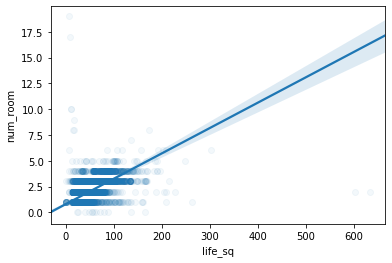

In [329]:
sns.regplot(x=train['life_sq'], y=train['num_room'], scatter_kws={'alpha':0.05})

In [330]:
train.loc[:, 'num_room was missing'] = train['num_room'].isnull()

In [331]:
train.loc[train['num_room'].isnull(), 'num_room'] = np.round(train.loc[train['num_room'].isnull(), 'life_sq'] / 23)

In [332]:
strange_subareas = list(set(train[(train['kindergarten_km'] > 10) | (train['school_km'] > 10) | \
                  (train['park_km'] > 10) | (train['public_transport_station_km'] > 10)]['sub_area'].values))

In [333]:
for area in strange_subareas:
    print(train.loc[train['sub_area'] == area, ['kindergarten_km', 'school_km', 'park_km', \
                                            'public_transport_station_km']].describe())

       kindergarten_km  school_km    park_km  public_transport_station_km
count         1.000000   1.000000   1.000000                     1.000000
mean         12.660125  26.031705  27.871759                     1.922814
std                NaN        NaN        NaN                          NaN
min          12.660125  26.031705  27.871759                     1.922814
25%          12.660125  26.031705  27.871759                     1.922814
50%          12.660125  26.031705  27.871759                     1.922814
75%          12.660125  26.031705  27.871759                     1.922814
max          12.660125  26.031705  27.871759                     1.922814
       kindergarten_km  school_km    park_km  public_transport_station_km
count        92.000000  92.000000  92.000000                    92.000000
mean          1.495999   0.364635  16.213606                     0.214015
std           0.247831   0.176009   0.284205                     0.108861
min           1.065537   0.095827  15.

       kindergarten_km   school_km     park_km  public_transport_station_km
count       362.000000  362.000000  362.000000                   362.000000
mean          4.436967    7.855184    9.799696                     1.667150
std           0.371758    0.595336    0.505303                     0.315517
min           1.869430    6.537239    8.373373                     0.680144
25%           4.415205    7.671322    9.684197                     1.791212
50%           4.415205    7.671322    9.684197                     1.791212
75%           4.415205    7.671322    9.684197                     1.791212
max           5.770857   11.411395   12.971092                     2.167775
       kindergarten_km  school_km    park_km  public_transport_station_km
count         2.000000   2.000000   2.000000                     2.000000
mean          9.015731  13.970146  13.148095                     5.630601
std           0.088624   0.067529   0.090087                     0.128678
min           8.9530

Strangely enough all this data is correct according to sub area location and whole dataframe info

In [337]:
train.columns[train.isna().sum() > 0]

Index(['material', 'state', 'preschool_quota', 'school_quota',
       'hospital_beds_raion', 'raion_build_count_with_material_info',
       'build_count_block', 'build_count_wood', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk',
       'metro_km_walk', 'railroad_station_walk_km',
       'railroad_station_walk_min', 'ID_railroad_station_walk',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
       'cafe_sum_

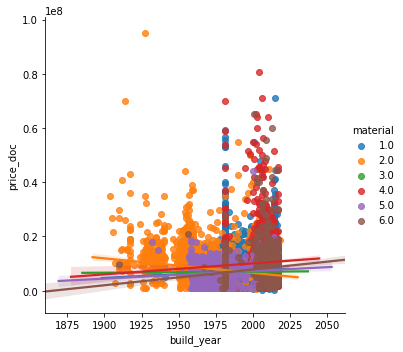

In [340]:
sns.scatterplot(x='build_year', y='price_doc', hue='material', data=train[train['build_year'] > 1900], alpha=0.05)

In [347]:
train.loc[pd.isnull(train['material']), ['full_sq', 'life_sq', 'build_year','num_room']].describe()

,full_sq,life_sq,build_year,num_room
count,9571.000000,9571.000000,9571.0,9571.000000
mean,53.284714,32.403929,1981.0,1.412183
std,25.152785,14.926649,0.0,0.669139
min,6.000000,0.000000,1981.0,0.000000
25%,38.000000,21.000000,1981.0,1.000000
50%,47.000000,29.000000,1981.0,1.000000
75%,62.000000,40.000000,1981.0,2.000000
max,729.000000,250.000000,1981.0,11.000000


In [350]:
train.loc[pd.isnull(train['material']), 'build_year was_missing'].shape[0] - \
train.loc[pd.isnull(train['material']), 'build_year was_missing'].sum()

0

It seems like all the houses with unknown material previously had build_year = NAN

In [351]:
train.loc[:, 'material'].fillna(7, inplace=True)

In [355]:
train['state'].isna().sum()

13558

In [354]:
train[pd.isnull(train['state'])].describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,area_m,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
count,13558.000000,13558.000000,13558.000000,13558.000000,13558.000000,13558.000000,13558.000000,13558.000000,0.0,1.355800e+04,...,13558.000000,13558.000000,13558.000000,13558.000000,13558.000000,1.355800e+04,13558.000000,13558.000000,13558.000000,13558.000000
mean,54.211462,37.809854,8.039165,11.422997,5.409574,1981.547278,1.537837,16.401608,NaN,2.018414e+07,...,28.057162,0.456557,7.749004,47.205119,5.212568,6.479527e+06,0.698423,1.554046,8.722212,0.585905
std,24.932303,20.245469,5.412008,5.203827,2.569483,6.831080,0.736417,15.328115,NaN,2.201242e+07,...,46.752707,0.607780,20.299351,46.275160,4.784424,4.449597e+06,0.166528,1.534227,18.150091,1.558168
min,6.000000,0.000000,0.000000,1.000000,1.000000,1890.000000,0.000000,0.000000,NaN,2.081628e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000e+05,0.012658,1.000000,0.012658,0.001575
25%,38.000000,25.000000,4.000000,8.000000,2.000000,1981.000000,1.000000,9.000000,NaN,7.587523e+06,...,7.000000,0.000000,0.000000,9.000000,1.000000,4.371716e+06,0.596154,1.222222,1.409091,0.250000
50%,49.000000,33.000000,7.000000,8.000000,7.000000,1981.000000,1.000000,16.000000,NaN,1.139168e+07,...,14.000000,0.000000,1.000000,37.000000,4.000000,5.745425e+06,0.656250,1.523810,1.809524,0.552632
75%,63.000000,45.000000,12.000000,16.000000,7.000000,1981.000000,2.000000,21.000000,NaN,2.553630e+07,...,26.000000,1.000000,5.000000,71.000000,9.000000,7.400000e+06,0.818182,1.677419,4.000000,0.709677
max,729.000000,634.000000,44.000000,99.000000,7.000000,2017.000000,11.000000,685.000000,NaN,2.060718e+08,...,250.000000,2.000000,105.000000,218.000000,20.000000,1.111111e+08,1.000000,79.000000,635.000000,79.000000


House's state is a parameter, that can't be related to any other parameter of the house, so the best option is to make a mark that it was missing

In [361]:
missed_features = np.array(['preschool_quota', 'school_quota',
       'hospital_beds_raion', 'raion_build_count_with_material_info',
       'build_count_block', 'build_count_wood', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk',
       'metro_km_walk', 'railroad_station_walk_km',
       'railroad_station_walk_min', 'ID_railroad_station_walk',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
       'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000',
       'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
       'cafe_avg_price_3000', 'prom_part_5000', 'cafe_sum_5000_min_price_avg',
       'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000'])

In [362]:
train[missed_features].isna().sum()

preschool_quota                           6687
school_quota                              6684
hospital_beds_raion                      14440
raion_build_count_with_material_info      4990
build_count_block                         4990
build_count_wood                          4990
build_count_frame                         4990
build_count_brick                         4990
build_count_monolith                      4990
build_count_panel                         4990
build_count_foam                          4990
build_count_slag                          4990
build_count_mix                           4990
raion_build_count_with_builddate_info     4990
build_count_before_1920                   4990
build_count_1921-1945                     4990
build_count_1946-1970                     4990
build_count_1971-1995                     4990
build_count_after_1995                    4990
metro_min_walk                              25
metro_km_walk                               25
railroad_stat

In [373]:
for feature in missed_features:
    train[feature + ' was missing'] = train[feature].isnull()
    for area in set(train['sub_area'].values):
        train.loc[(train['sub_area'] == area) & (pd.isnull(train[feature])), feature] = \
        train[(train['sub_area'] == area) & (~pd.isnull(train[feature]))][feature].median()

In [385]:
train[missed_features].isna().sum()

preschool_quota                           6687
school_quota                              6684
hospital_beds_raion                      14440
raion_build_count_with_material_info      4990
build_count_block                         4990
build_count_wood                          4990
build_count_frame                         4990
build_count_brick                         4990
build_count_monolith                      4990
build_count_panel                         4990
build_count_foam                          4990
build_count_slag                          4990
build_count_mix                           4990
raion_build_count_with_builddate_info     4990
build_count_before_1920                   4990
build_count_1921-1945                     4990
build_count_1946-1970                     4990
build_count_1971-1995                     4990
build_count_after_1995                    4990
metro_min_walk                               0
metro_km_walk                                0
railroad_stat

I don't see a reasonable way to recover these values so the best option is to fill in the values with imputer.